In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
path=Path.cwd().joinpath('Data')
from Utils import SpEC_class_2 as spu
# set maplotlib font size to 12
plt.rcParams.update({'font.size': 12})

In [1]:
# glob through data
files = path.glob('*.parquet')
PD_spectra_dict={}
PD_files=[file for file in files if 'PD_spectra' in str(file)]

spectra_dict={}
for file in PD_files:
    spectra_dict[file.stem.split('_')[-1]]=pd.read_parquet(file)

# note that I'm going to plot all the kientcs at 750 nm as the slow kinetics of 1.4 V does not vary with
# wavelength. Normally one needs to be careful about always plotting at a wavelength you are certain tracks
#only the kinetics of interest.

print(spectra_dict.keys())

NameError: name 'path' is not defined

In [ ]:
# for key in sorted(spectra_dict.keys()):
#     (spectra_dict[key].loc[750]).plot()

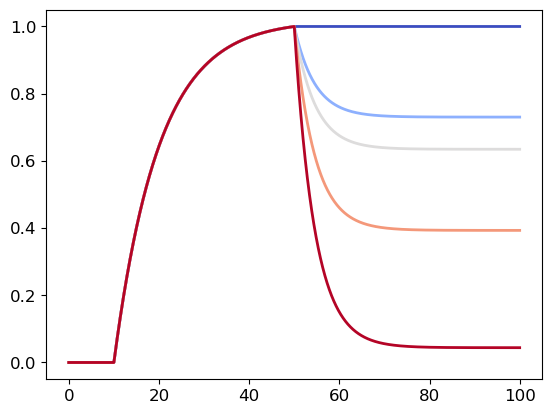

In [ ]:
# generate a cool warm colormap the lenth of spectra_dict

cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, len(spectra_dict))]

for i, key in enumerate(sorted(spectra_dict.keys())):
    if key != '1.4':
        (spectra_dict[key].loc[550]/spectra_dict[key].loc[550].values.max()).plot(linewidth=2, color = colors[i], )
    else:
        (spectra_dict[key].loc[750]/spectra_dict[key].loc[750].values.max()).plot(linestyle='--', linewidth=2, color = colors[i])

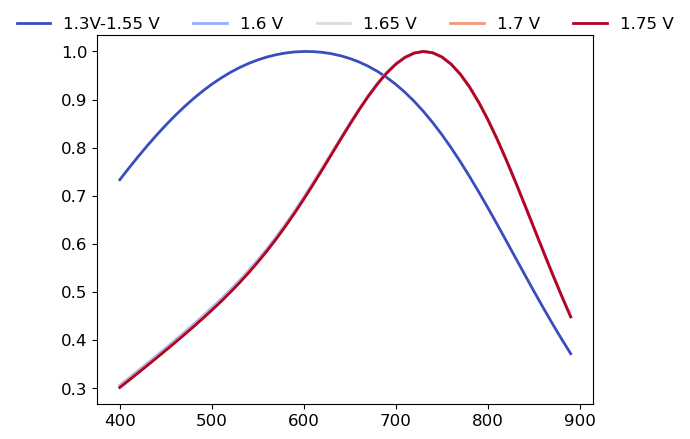

In [ ]:
# create a coolwarm 
for i, ( key, spectrum) in enumerate(sorted(spectra_dict.items())):
    
    max_spec = spectrum[50.0]
    max_spec = max_spec/max_spec.max()
    if key == '1.4':
        max_spec.plot(label=f'{key} V',linewidth=2, color = colors[i], linestyle='--')
    else:
        max_spec.plot(label=f'{key} V',linewidth=2, color = colors[i])

# add a legend above the plot, horizontal, no frame
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.09), shadow=True, ncol=5, frameon = False)
    

In [ ]:
"""a note on this analysis - normally the way one would do an an inital rates ananlysis is to fit a line
through a small region just as the reaction starts. However, in the case of this rather nice synthetic data
or data with a very high signal to noise ratio, we can simply take the derivative of the kinetics WRT time 
 and then evaulate the derivative at a time point of interest. This is what I'm going to do here. However, I would
 reccomend stuicking with the line fitting method for real data!"""

# take the detivative of the kinetics
PD_init_rate_J={}

for key, spectrum in sorted(spectra_dict.items()):
    if key != '1.4':
        # get the kinetics
        kinetics = spectrum.loc[750]
        # take the derivative first with respect to the index
        dy = kinetics.diff()
        dx = kinetics.index.to_series().diff()
        dy_dx = abs((dy/dx).min()) # the minimum is a good way to get the intial rate
        #scatter plot of float(key) and dy_dx
        # plt.scatter(float(key), dy_dx)

        
        # print(key, dy_dx/5)
        PD_init_rate_J[key]=dy_dx/5

        """To convert the rate of optical decay to a inital rate, measured in the units of current, we divide 
        by the coulmetric differential attenuation coeffcient of process 3. I leave it to the reader to use the 
        code provided to calcualte this value using the method shown for process 1. Here I simply use the ground
        truth value of 5.0"""

# drop the collumn '1.3V-1.55' - it is not from a valid potential
PD_init_rate_J.pop('1.3V-1.55') 

1.6491121763292817e-06

$$\frac{d\Delta A}{dt}=\frac{dQ}{dt}\frac{dU}{dt} \cdot \Delta \alpha$$

Where $\frac{dU}{dt}$ is the scan rate.

Text(0, 0.5, 'J ($mA$ $cm^{-2}$)')

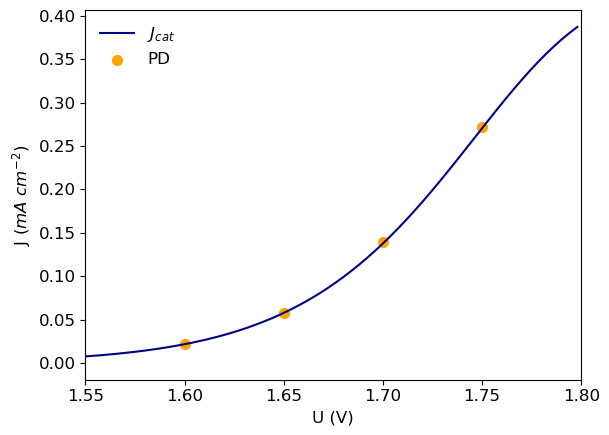

In [ ]:
"""I am simply going to load the ground truth catalytic current here. I leave an excercise to the reader to 
estimate this value by taking the total current and subtracting the capaciative current using the Eqn above """


J_cat = pd.read_parquet(path.joinpath('J_BEP_SpEC.parquet'))

# round the index to 3 decimal place
J_cat.index = J_cat.index.round(4)
#
#rename the first collumn J_cat
J_cat.columns = [r'$J_{cat}$']

#multiply the first collumn of J)cat by 1e3 to get it in mA
J_cat = J_cat*1e3
fig, ax = plt.subplots()
J_cat.plot(ax=ax, legend=False, color='darkblue')
plt.scatter([float(key) for key in PD_init_rate_J.keys()], [PD_init_rate_J[key]*1000 for key in PD_init_rate_J.keys()], label='PD', color='orange',s=50)
# set the x lim to 1.55 to 1.8 

plt.xlim(1.55, 1.8)
#xlabel
plt.xlabel('U (V)')
plt.legend(frameon=False)
plt.ylabel(r'J ($mA$ $cm^{-2}$)')
# custom legend for both the scatter and the line plot



# scatter plot with the inital rates using the key as the x axis


In [ ]:
J_cat

,$J_{cat}$
U,
0.400,5.471442e-21
0.402,5.916040e-21
0.404,6.396764e-21
0.406,6.916551e-21
0.408,7.478575e-21
...,...
1.790,3.727604e-01
1.792,3.766419e-01
1.794,3.803764e-01


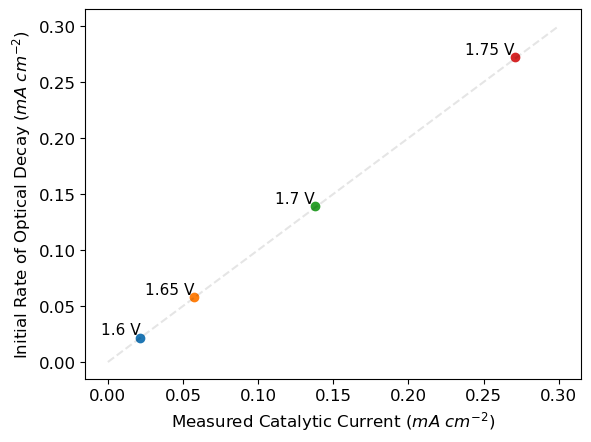

In [ ]:
J_comp_dict = {}
for key, value in PD_init_rate_J.items():
    J_cat_value = J_cat.loc[float(key)].iloc[0]
    J_comp_dict[key] = (J_cat_value, PD_init_rate_J[key])
    plt.scatter(J_cat_value, PD_init_rate_J[key] * 1000, label=key)
    # Add text for each point being the key, place the text a little above the point
    plt.text(J_cat_value, PD_init_rate_J[key] * 1000, f'{key} V', verticalalignment='bottom', horizontalalignment='right', fontsize=11)

# x label measured catalytic current
# initial rate of optical decay
plt.xlabel(r'Measured Catalytic Current ($mA$ $cm^{-2}$)')
plt.ylabel(r'Initial Rate of Optical Decay ($mA$ $cm^{-2}$)')

# Add a line of best fit gradient 1 through the origin
x = np.linspace(0, 0.3, 100)
plt.plot(x, x, linestyle='--', color='black', alpha=0.1)

Text(0.5, 0, 'Wavelength (nm)')

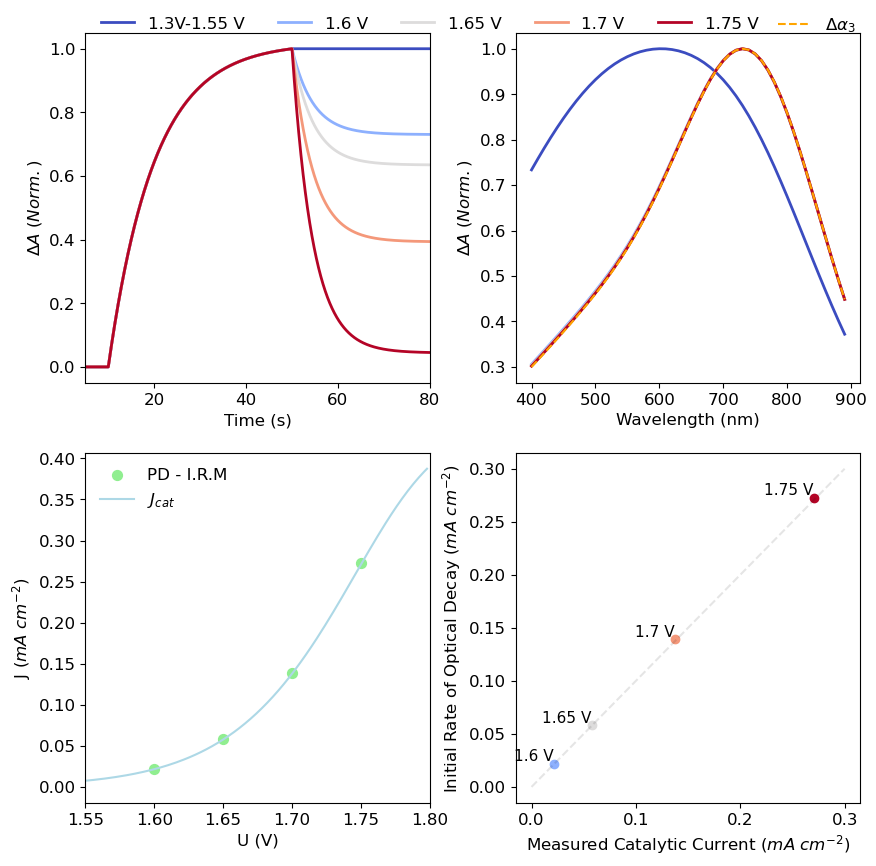

In [ ]:
# combined the four plots above into a single 2x2 panel 
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# plot the kinetics at 750 nm for each potential
for i, key in enumerate(sorted(spectra_dict.keys())):
    if key != '1.4':
        (spectra_dict[key].loc[550] / spectra_dict[key].loc[550].values.max()).plot(linewidth=2, color=colors[i], ax=ax[0, 0], label=f'{key} V')
    else:
        (spectra_dict[key].loc[750] / spectra_dict[key].loc[750].values.max()).plot(linestyle='--', linewidth=2, color=colors[i], ax=ax[0, 0], label=f'{key} V')
ax[0, 0].legend(loc='upper center', bbox_to_anchor=(1, 1.09), shadow=True, ncol=5, frameon=False)


for i, (key, spectrum) in enumerate(sorted(spectra_dict.items())):
    max_spec = spectrum[50.0]
    max_spec = max_spec / max_spec.max()
    if key == '1.4':
        max_spec.plot(label=f'{key} V', linewidth=2, color=colors[i], linestyle='--', ax=ax[0, 1])
    else:
        max_spec.plot(label=f'{key} V', linewidth=2, color=colors[i], ax=ax[0, 1])
ax[0,0].set_xlim(5,80)
#ax 0 0 y label $\Delta A \ (Norm.)$ x label Time (s)
ax[0, 0].set_ylabel(r'$\Delta A \ (Norm.)$')
ax[0, 0].set_xlabel('Time (s)')

#ax [0,1] y label $\Delta A \ (Norm.)$ x label Wavelength (nm)
ax[0, 1].set_ylabel(r'$\Delta A \ (Norm.)$')
ax[0, 1].set_xlabel('Wavelength (nm)')
# no legend
ax[0, 1].legend().remove()

# plot the initial rates
ax[1, 0].scatter([float(key) for key in PD_init_rate_J.keys()], [PD_init_rate_J[key] * 1000 for key in PD_init_rate_J.keys()], label='PD - I.R.M', color='lightgreen', s=50)
J_cat.plot(ax=ax[1, 0], legend=False, color='lightblue')
ax[1, 0].set_xlim(1.55, 1.8)
ax[1, 0].set_xlabel('U (V)')
ax[1, 0].set_ylabel(r'J ($mA$ $cm^{-2}$)')
# custom legend for both the scatter and the line plot
ax[1, 0].legend(frameon=False)

J_comp_dict = {}
for i, (key, value) in enumerate(PD_init_rate_J.items()):
    J_cat_value = J_cat.loc[float(key)].iloc[0]
    J_comp_dict[key] = (J_cat_value, PD_init_rate_J[key])
    ax[1, 1].scatter(J_cat_value, PD_init_rate_J[key] * 1000, label=key, color=colors[i+1])
    # Add text for each point being the key, place the text a little above the point
    ax[1, 1].text(J_cat_value, PD_init_rate_J[key] * 1000, f'{key} V', verticalalignment='bottom', horizontalalignment='right', fontsize=11)

# x label measured catalytic current
# initial rate of optical decay
ax[1, 1].set_xlabel(r'Measured Catalytic Current ($mA$ $cm^{-2}$)')
ax[1, 1].set_ylabel(r'Initial Rate of Optical Decay ($mA$ $cm^{-2}$)')

# Add a line of best fit gradient 1 through the origin
x = np.linspace(0, 0.3, 100)
ax[1, 1].plot(x, x, linestyle='--', color='black', alpha=0.1)

#add space between the subplots
plt.subplots_adjust(hspace=0.2, wspace=0.25)

# finally read in comp3spectrum.csv and plot it in [0,1]
comp3 = pd.read_csv(path.joinpath('comp3spectrum.csv'))

#set the index to the first collumn
comp3.index = comp3.iloc[:, 0]
#drop the first collumn
comp3 = comp3.drop(comp3.columns[0], axis=1)

# set the collumn name to f'$\Delta \alpha_{3}$'
comp3.columns = [r'$\Delta \alpha_{3}$']
#plot the comp3 spectrum
comp3.plot(ax=ax[0, 1], legend=True, color='orange', linestyle='--', linewidth=1.5)

# add a legend saying comp3, no frame placed above the plot
ax[0, 1].legend(frameon=False, bbox_to_anchor=(1.1, 1.1))

# remove all but delta A 3 from the legend
handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 1].legend([handles[-1]], [labels[-1]], frameon=False, bbox_to_anchor=(1.03, 1.09))
ax[0,1].set_xlabel('Wavelength (nm)')
#add a legend saying comp3, no frame placed above the plot
